# MMGモデルを使ってFMI/FMUで遊ぼう

- 基本的には、KT_FMU.ipynbと同じ構造です

## このNotebookの動作環境について

- JModelicaを利用してFMUを作成し、作成したFMUを使ってJupyterNotebook上でCo-simulationを実行するサンプルです

- ここでは、DockerHubにある[taiga4112/jmodelica:jm0](https://hub.docker.com/repository/docker/taiga4112/jmodelica)のイメージを利用して以下のコマンドでJupyterを起動し、起動したJupyter上でこのノートブックを動作させることを想定している
    - [taiga4112/jmodelica:jm0](https://hub.docker.com/repository/docker/taiga4112/jmodelica)は、この[ページ](https://www.amane.to/archives/710)に従ってContainer Imageを作成してPushしたもの
        - 本当はJModelicaに登録しないといけないっぽいので、あくまで私的利用のためにお使いください（はーと）

```sh
$ docker pull taiga4112/jmodelica:jm0
$ docker run -it --rm --name ktjm -p 8888:8888 \
    -u root -v $(pwd)/notebooks:/home/jmodelica/jmodelica \
    taiga4112/jmodelica:jm0 /usr/local/jmodelica/bin/jm_start.sh
```
    
- コマンド実行後、[http://localhost:8888](http://localhost:8888)にアクセスする
    - Access Tokenは`jmodelica`です

### JModelica

> JModelica.org は、Modelica 言語に基づいて複雑な動的システムのモデル化、シミュレーション、最適化および分析などを行うプラットフォームとなるソフトウェアです。モデルは Modelica 言語で記述しますが、オペレーションのほとんどは Python を使用して行います。Lund 大学などの学術機関と民間企業の協力を得て、Modelon AB によってオープンソースソフトウェアとして維持開発されてきました。Modelon は、2019年12月18日に、Assimulo, PyFMI, FMI Library を除くコンパイラや最適化機能など含む部分を一般に使用可能なオープンソースとすることを止めてしまいました。今後も商用および学術的用途で利用されるソフトウェアとして開発は続けられるそうです。
> 
> 現在、https://jmodelica.org/ のフォームに登録することによって、最後のオープンソースバージョンのソースコードと Windows用バイナリのダウンロードが可能です。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymodelica import compile_fmu
from pyfmi import load_fmu
from pyfmi.master import Master
%matplotlib inline

## A. MMG_3DOFモデルの作成



In [2]:
%%writefile MMG_3DOF.mo
model MMG_3DOF
    
    import SI = Modelica.SIunits;
    import Math = Modelica.Math;

    // Ship Basic Parameters
    parameter SI.Length L = 2.19048; // 船長Lpp[m]
    parameter SI.Length B = 0.3067; // 船幅[m]
    parameter SI.Length d = 0.10286; // 喫水[m]
    parameter SI.Volume nabla = 0.04495; // 排水量[m^3]
    parameter Real xG = 0.0; // 重心位置[-]
    parameter Real kzz_Lpp = 0.25; // 船長あたりの付加質量[]
    parameter SI.Length Dp = 0.0756; // プロペラ直径[m]
    // parameter Real Cb = 0.6505; // 方形係数[-]
    parameter Real m_ = 0.1822; // 質量(無次元化)[-]
    parameter Real Izz = 0.01138; // 慣性モーメント[-]
    parameter Real Lambda = 2.1683; // アスペクト比[-]
    parameter Real AR_Ld = 0.01867; // 船の断面に対する舵面積比[-]
    parameter Real eta = 0.7916; // プロペラ直径に対する舵高さ(Dp/H)
    parameter Real mx = 0.00601; // 付加質量x(無次元)
    parameter Real my = 0.1521; // 付加質量y(無次元)
    parameter Real Jzz = 0.00729; // 付加質量Izz(無次元)
    parameter Real fa = (6.13*Lambda)/(2.25+Lambda); // 直圧力勾配係数
    parameter Real epsilon = 0.90; // プロペラ・舵位置伴流係数比
    parameter Real tR = 0.441; // 操縦抵抗減少率
    parameter Real aH = 0.232; // 舵力増加係数
    parameter Real xH = -0.711; // 舵力増分作用位置
    parameter Real gammaR = 0.4115; // 整流係数
    parameter Real lr = -0.774; // 船長に対する舵位置
    parameter Real kappa = 0.713; // 修正係数
    parameter Real kx = 0.6417; // 流速増加修正係数
    parameter Real tP = 0.20; // 推力減少率
    parameter Real wpo = 0.326; // 有効伴流率
    
    // Maneuvering Parameters
    parameter Real C1 = 0.48301; // クラスタ特性係数C1
    parameter Real C2 = -0.29765; // クラスタ特性係数C2
    parameter Real C3 = -0.16423; // クラスタ特性係数C3
    parameter Real X_0 = -0.07234; // 線形微係数
    parameter Real X_beta_beta = -0.23840;
    parameter Real X_beta_gamma = -0.03231 + my;
    parameter Real X_gamma_gamma = -0.06405;
    parameter Real X_beta_beta_beta_beta = -0.30047;
    parameter Real Y_beta = 0.85475;
    parameter Real Y_gamma = 0.11461 + mx;
    parameter Real Y_beta_beta_beta = 6.73201;
    parameter Real Y_beta_beta_gamma = -2.23689;
    parameter Real Y_beta_gamma_gamma = 3.38577;
    parameter Real Y_gamma_gamma_gamma = -0.04151;
    parameter Real N_beta = 0.096567;
    parameter Real N_gamma = -0.036501;
    parameter Real N_beta_beta_beta = 0.14090;
    parameter Real N_beta_beta_gamma = -0.46158;
    parameter Real N_beta_gamma_gamma = 0.01648;
    parameter Real N_gamma_gamma_gamma = -0.030404;
    
    // Environments Parameters
    parameter Real rho = 1.025;
    
    // State start values
    parameter SI.Velocity u_0 = 1.21;
    parameter SI.Velocity v_0 = 0;
    parameter SI.AngularVelocity r_0 = 0;
    
    // The states
    output SI.Velocity u(start = u_0);
    output SI.Velocity v(start = v_0);
    output SI.AngularVelocity r(start = r_0);
    
    // The control signal
    input SI.Angle delta;
    input Real npm; // エンジン回転数[rpm]
    
    // The states of simulation
    SI.Velocity U; // 合速度
    SI.Angle beta; // 斜航角
    SI.AngularVelocity gamma_dash; // 無次元化された回頭角速度
    Real J; // 前進常数
    Real K_T; // スラスト係数
    SI.Velocity v_R; // 舵に流入する横方向速度成分
    SI.Velocity u_R; // 舵に流入する前後方向速度成分
    SI.Velocity U_R; // 舵への流入速度
    SI.Angle alpha_R; // 舵への流入角度
    Real F_N; // 舵直圧力
    Real X_H; // 斜航，旋回時の船体に作用する前後方向の流体力
    Real R_0; // 直進時の船体抵抗
    Real X_R; // 斜航，旋回時の舵に作用する前後方向の流体力
    Real X_P; // プロペラ推力
    Real Y_H; // 斜航，旋回時の船体に作用する横方向の流体力
    Real Y_R; // 斜航，旋回時の舵に作用する横方向の流体力
    Real N_H; // 斜航，旋回時の船体に作用する回頭モーメント
    Real N_R; // 斜航，旋回時の舵に作用する回頭モーメント
    
equation
    
    U = sqrt(u^2 + ( v - r * xG )^2);
    beta = if U < 0.001 then 0.0 else Math.asin( - ( v - r * xG ) / U); // "=="がcompileできない？？
    
    gamma_dash = if U < 0.001 then 0.0 else ( r * L ) / U;
    J = if npm < 0.001 then 0.0 else (1.0 - wpo) * u / (npm / Dp);
    K_T = C1 + C2 * J + C3 * (J^2);
    v_R = U * gammaR * ( sin(beta) - lr * gamma_dash );
    u_R = if J < 0.001 then u * (1 - wpo) else sqrt(eta * ( kappa * epsilon * 8.0 * C1 * (npm^2) * (Dp^4) )^2);
    U_R = sqrt( u_R^2 + v_R^2 );
    alpha_R = delta - atan2(v_R, u_R);
    F_N = AR_Ld * fa * (U_R^2) * sin(alpha_R);
    
    X_H = 0.5*rho*L*d*(U^2)*(X_0+X_beta_beta*(beta^2)+X_beta_gamma*beta*gamma_dash+X_gamma_gamma*(gamma_dash^2)+X_beta_beta_beta_beta*(beta^4));
    R_0 = 0.0;
    X_R = -(1.0-tR)*F_N*sin(delta)/L;
    X_P = (1.0-tP)*rho*K_T*(npm^2)*(Dp^4)*(2.0/(rho*d*(L^2)));
    Y_H = 0.5*rho*L*d*(U^2)*(Y_beta*beta+Y_gamma*gamma_dash+Y_beta_beta_gamma*(beta^2)*gamma_dash+Y_beta_gamma_gamma*beta*(gamma_dash^2)+Y_beta_beta_beta*(beta^3)+Y_gamma_gamma_gamma*(gamma_dash^3));
    Y_R = -(1+aH)*F_N*cos(delta)/L;
    N_H = 0.5*rho*(L^2)*d*(U^2)*(N_beta*beta+N_gamma*gamma_dash+N_beta_beta_gamma*(beta^2)*gamma_dash+N_beta_gamma_gamma*beta*(gamma_dash^2)+N_beta_beta_beta*(beta^3)+N_gamma_gamma_gamma*(gamma_dash^3));
    N_R = -(-0.5+aH*xH)*F_N*cos(delta)/(L^2);
    
    der(u) = ((X_H-R_0+X_R+X_P)+(m_+my)*v*r)/(m_+mx);
    der(v) = ((Y_H+Y_R)-(m_+mx)*u*r)/(m_+my);
    der(r) = (N_H+N_R)/(Izz+Jzz);
    
end MMG_3DOF;

Overwriting MMG_3DOF.mo


FMI2.0 for Co-Simualtion の規格に従う KT_3DOF モデルの FMUファイル を生成します。

In [3]:
fmu = compile_fmu("MMG_3DOF","MMG_3DOF.mo", version='2.0', target='cs',compile_to = "MMG_3DOF.fmu")

まずはこれだけを動かしてみるっす

###  1. 操作量(舵角&回転数)の設定

In [4]:
duration = 50  #[s]
sampling = 2000

time_list = np.linspace(0.00, duration, sampling)
# Ts = 10.0
# delta_rad_list = 20.0 * np.pi / 180.0  * np.sin(2.0 * np.pi / Ts * time_list) # [rad]
# delta_rad_list = np.array([30.0* np.pi / 180.0 for i in range(sampling)])
delta_rad_list = [0]*sampling
for i in range(sampling):
    if (i >= 400) :
        delta_rad_list[i] = 30.0* np.pi /180.0
    else:
        delta_rad_list[i] = 0

n_const = 20.338
npm_list = np.array([n_const for i in range(sampling)])

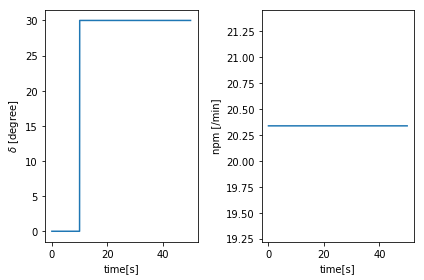

In [5]:
plt.subplot(1,2,1)
plt.plot(time_list, np.rad2deg(delta_rad_list))
plt.xlabel('time[s]')
plt.ylabel(r'$\delta$ [degree]')
plt.subplot(1,2,2)
plt.plot(time_list, npm_list)
plt.xlabel('time[s]')
plt.ylabel('npm [/min]')
plt.tight_layout()

FMUに入力するためのデータ変換

In [6]:
traj = np.transpose(np.vstack((time_list, delta_rad_list, npm_list)))
input_info =  (['delta', 'npm'], traj)

In [7]:
input_info

(['delta', 'npm'],
 array([[  0.00000000e+00,   0.00000000e+00,   2.03380000e+01],
        [  2.50125063e-02,   0.00000000e+00,   2.03380000e+01],
        [  5.00250125e-02,   0.00000000e+00,   2.03380000e+01],
        ..., 
        [  4.99499750e+01,   5.23598776e-01,   2.03380000e+01],
        [  4.99749875e+01,   5.23598776e-01,   2.03380000e+01],
        [  5.00000000e+01,   5.23598776e-01,   2.03380000e+01]]))

### 2. FMUファイルの読み込みとシミュレーション実行

In [8]:
# FMUの読み込み
model_mmg3dof = load_fmu("MMG_3DOF.fmu")
# Parameterの設定
# model_kt3dof.set('K', 50)
# model_kt3dof.set('T', 70)
# Simulation
result = model_mmg3dof.simulate(final_time=50, input=input_info)

Simulation interval    : 0.0 - 50.0 seconds.
Elapsed simulation time: 0.027599811554 seconds.


とりあえず結果確認

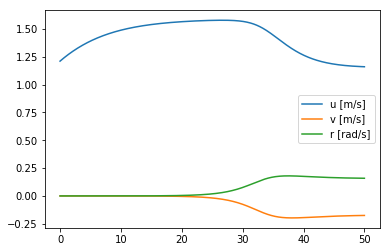

In [9]:
u = result['u']
v = result['v']
r = result['r']
t = result['time']
plt.plot(t, u, t, v, t, r)
plt.legend(('u [m/s]','v [m/s]', 'r [rad/s]'));

## B. 操作量コントロールモジュールの導入
- 今回はZ試験を実現するRudder Controlモジュールを導入してみた



`ShipCondition.mo`は`KT_FMU.ipynb`で作成したものを利用する
ただ、再度作成したい場合は以下のコードをコメントアウトして利用してください

In [10]:
# %%writefile ShipCondition.mo
# model ShipCondition

#     import SI = Modelica.SIunits;
    
#     // State start values
#     parameter SI.Position x_0 = 0;
#     parameter SI.Position y_0 = 0;
#     parameter SI.Angle psi_0 = 0;
    
#     // The states
#     output SI.Position x(start = x_0);
#     output SI.Position y(start = y_0);
#     output SI.Angle psi(start = psi_0);
    
#     // The control signal
#     input SI.Velocity u;
#     input SI.Velocity v;
#     input SI.AngularVelocity r;
    
# equation
#     der(x) = u * cos(psi) + v * sin(psi);
#     der(y) = u * sin(psi) + v * cos(psi);
#     der(psi) = r;
# end ShipCondition;

In [11]:
# fmu = compile_fmu("ShipCondition","ShipCondition.mo", version='2.0', target='cs',compile_to = "ShipCondition.fmu")

In [12]:
%%writefile Control_delta_npm.mo
model Control_delta_npm
    
    import SI = Modelica.SIunits;
    import Modelica.SIunits.Conversions.*;
    
    // State start values
    parameter SI.Angle delta_0 = from_deg(20);
    parameter Real npm_0 = 20.833;
    
    // Setting param
    parameter Real psi_min = from_deg(-10);
    parameter Real psi_max = from_deg(+10);
    
    // The states
    output SI.Angle delta(start = delta_0);
    output Real npm(start = npm_0);
    
    // The control signal
    input SI.Angle psi;
    input SI.Velocity u; // not_used
    input SI.Velocity v; // not_used
    
equation
    npm = npm_0;
    when psi >= psi_max then
        delta = from_deg(-20);
    elsewhen psi <= psi_min then
        delta = from_deg(20);
    end when;
end Control_delta_npm;

Overwriting Control_delta_npm.mo


In [13]:
fmu = compile_fmu("Control_delta_npm","Control_delta_npm.mo", version='2.0', target='cs',compile_to = "Control_delta_npm.fmu")

本当は、コメントアウトしている部分をつけたいんだけど、これがあると何故かうまく行かない・・・なんでだろう・・・
別々に分けたほうがいいのかしら・・・

In [14]:
model_mmg3dof = load_fmu("MMG_3DOF.fmu")
model_shipcondition = load_fmu("ShipCondition.fmu")
model_ruddercontrol = load_fmu("Control_delta_npm.fmu")
models = [model_mmg3dof, model_shipcondition, model_ruddercontrol]
connections = [
    (model_mmg3dof, "u", model_shipcondition,"u"), 
    (model_mmg3dof, "v", model_shipcondition,"v"), 
    (model_mmg3dof, "r", model_shipcondition,"r"),
    (model_shipcondition, "psi", model_ruddercontrol, "psi"),
    (model_mmg3dof, "u", model_ruddercontrol, "u"),
    (model_mmg3dof, "v", model_ruddercontrol, "v"),
    (model_ruddercontrol, "delta", model_mmg3dof, "delta"),
#     (model_ruddercontrol, "npm", model_mmg3dof, "npm"),
]
coupled_simulation = Master(models, connections)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The model, MMG_3DOF, does not support directional derivatives which is necessary in-case of an algebraic loop. The simulation might become unstable...
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The model, ShipCondition, does not support directional derivatives which is necessary in-case of an algebraic loop. The simulation might become unstable...
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The model, Control_delta_npm, does not support directional derivatives which is necessary in-case of an algebraic loop. The simulation might become unstable...
  from ipykernel import kernelapp as app


In [15]:
t_start = 0.0
t_end = 100.0
dt = (t_end - t_start)/1000
opts = coupled_simulation.simulate_options()
opts["step_size"] = dt
opts["linear_correction"] = False

res = coupled_simulation.simulate(start_time = t_start, final_time = t_end, options = opts)

Elapsed initialization time: 0.00145411491394 seconds.
Master Algorithm options:
 Algorithm             : Jacobi (fixed-step)
  Execution            : Serial
 Extrapolation Order   : 0
 Step-size             : 0.1
 Algebraic loop        : True
  Linear Correction    : False

Statistics: 
 Number of global steps        : 1000

Simulation interval      : 0.0 - 100.0 seconds.
Elapsed simulation time  : 0.260056018829 seconds.
 0.010878 seconds spent in MMG_3DOF.
 0.019642 seconds spent in ShipCondition.
 0.010746 seconds spent in Control_delta_npm.
 0.162120 seconds spent saving simulation result.


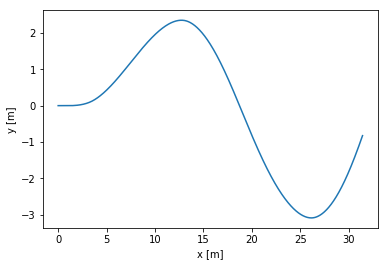

In [16]:
x = res[model_shipcondition]['x']
y = res[model_shipcondition]['y']
psi = res[model_ruddercontrol]['psi']
t = res[model_shipcondition]['time']

plt.plot(x, y)
plt.xlabel('x [m]')
plt.ylabel('y [m]');

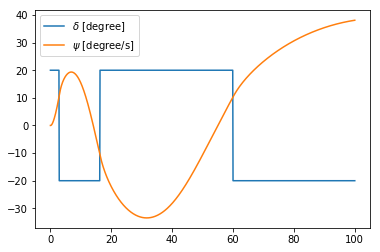

In [17]:
delta = np.rad2deg(res[model_ruddercontrol]['delta'])
psi = np.rad2deg(res[model_ruddercontrol]['psi'])
plt.plot(t, delta, label=r'$\delta$ [degree]')
plt.plot(t, psi, label=r'$\psi$ [degree/s]')
plt.legend();